# Data Pre-Processing

In [84]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [85]:
df = pd.read_csv(r"D:\US_Visa_MLOPS\dataset\EasyVisa.csv")
df.shape

(25480, 12)

# Data Cleaning
**Handling Missing Values**

In [86]:
feature_na = [feature for feature in df.columns if df[feature].isnull().sum()>=1]
for feature in feature_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), "%missng values")

In [87]:
feature_na

[]

* There are no missing values in the dataset

**Handling Duplicates**

In [88]:
df.duplicated().sum()

0

* There are no duplicates in the dataset

**Remove case_id from dataset as it has no impact**

In [89]:
df.drop('case_id',inplace=True,axis=1)

# Feature Engineering

**Feature Extraction**

In [90]:
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [91]:
from datetime import date
todays_date = date.today()
current_year = todays_date.year
current_year

2025

**Subract current yar with yr_of_estab feature to get the age of company and add the feature (age of company) to the dataframe**

In [92]:
df['company_age'] = current_year-df['yr_of_estab']
df.drop('yr_of_estab',inplace=True,axis=1)
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age
0,Asia,High School,N,N,14513,West,592.2029,Hour,Y,Denied,18
1,Asia,Master's,Y,N,2412,Northeast,83425.6500,Year,Y,Certified,23
2,Asia,Bachelor's,N,Y,44444,West,122996.8600,Year,Y,Denied,17
3,Asia,Bachelor's,N,N,98,West,83434.0300,Year,Y,Denied,128
4,Africa,Master's,Y,N,1082,South,149907.3900,Year,Y,Certified,20


**Split input and target features into X and Y**

In [93]:
Y = df['case_status']
X = df.drop('case_status',axis=1)
X.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,company_age
0,Asia,High School,N,N,14513,West,592.2029,Hour,Y,18
1,Asia,Master's,Y,N,2412,Northeast,83425.6500,Year,Y,23
2,Asia,Bachelor's,N,Y,44444,West,122996.8600,Year,Y,17
3,Asia,Bachelor's,N,N,98,West,83434.0300,Year,Y,128
4,Africa,Master's,Y,N,1082,South,149907.3900,Year,Y,20


In [94]:
Y.head()

0       Denied
1    Certified
2       Denied
3       Denied
4    Certified
Name: case_status, dtype: object

**Manual Encoding Target Variable**

In [95]:
#If the target variable is denied it is classified as denied else as 0
Y = np.where(Y=='Denied',1,0)
Y

array([1, 0, 1, ..., 0, 0, 0])

# Festure Transformation 
* Plot the distribution of numerical features

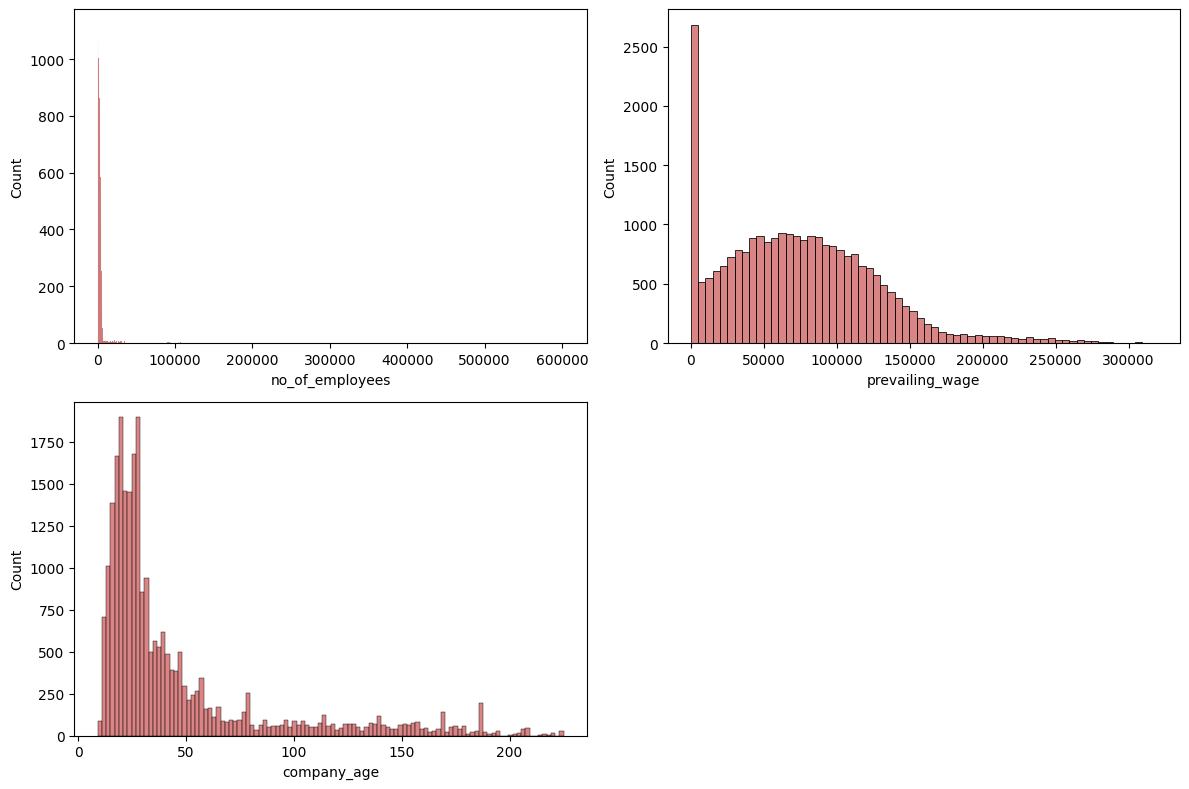

In [96]:
plt.figure(figsize=(12,8))
for i, col in enumerate(['no_of_employees','prevailing_wage','company_age']):
    plt.subplot(2,2,i+1)
    sns.histplot(x=X[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

* From the above plots we can see that the features no_of_employees and company_age are skewed
* Apply transformation (power transformation) to make them more gaussian

**Checking Skewness**

In [97]:
continous_features = ['no_of_employees','prevailing_wage','company_age']
X[continous_features].skew(skipna=True)

no_of_employees    12.265260
prevailing_wage     0.755776
company_age         2.037301
dtype: float64

* no_of_employees and company_age are positively skewed
* we can handle outliers and check the skewness again

# Apply Power Transformer to check if reduces the outliers and skewness

In [98]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
transorm_features = ['no_of_employees','company_age']
X_copy = pt.fit_transform(X[transorm_features])
X_copy = pd.DataFrame(X_copy, columns=transorm_features)

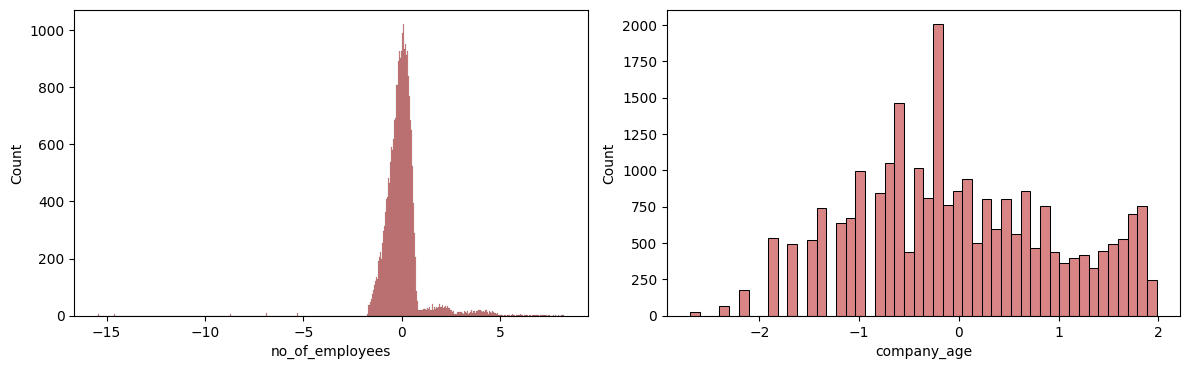

In [99]:
plt.figure(figsize=(12,7))
for i, col in enumerate(transorm_features):
    plt.subplot(2,2,i+1)
    sns.histplot(x=X_copy[col],color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

* Checking skewness after power transformation

In [100]:
X_copy[transorm_features].skew()

no_of_employees    0.399339
company_age        0.112260
dtype: float64

* Here yeo-johnson is used and it supports both positive and negative data for transformation
* So power transformer with yeo-johnson can be used

**Numerical Features**

In [101]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features))

Num of Numerical Features : 3


**Categorical Features**

In [102]:
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features))

Num of Categorical Features : 8


In [103]:
#number of unique categories in each feature
for feature in cat_features:
    print(feature,':',df[feature].nunique())

continent : 6
education_of_employee : 4
has_job_experience : 2
requires_job_training : 2
region_of_employment : 5
unit_of_wage : 4
full_time_position : 2
case_status : 2


# Feature Encoding and scaling 
* One-hot encoding for features with less unique values and not ordinal
* Oridinal encoding for features with more unique values and ordinal

**Pre-Processing using Column Transformer**

In [104]:
#Create a colum transformer using separate columns
or_columns = ['has_job_experience','requires_job_training','full_time_position','education_of_employee']
oh_columns = ['continent','unit_of_wage','region_of_employment']
transform_columns= ['no_of_employees','company_age']

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numreric_transformer = StandardScaler()
or_transformer = OrdinalEncoder()
oh_transformer = OneHotEncoder()

transform_pipeline = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer([
    ("OneHotEncoder",oh_transformer,oh_columns),
    ("OrdinalEncoder",or_transformer,or_columns),
    ("transformer",transform_pipeline,transform_columns),
    ("StandardScaler",numreric_transformer,num_features)
])

In [105]:
X = preprocessor.fit_transform(X)
X

array([[ 0.        ,  1.        ,  0.        , ...,  0.38666657,
        -1.39853722, -0.65122993],
       [ 0.        ,  1.        ,  0.        , ..., -0.14228155,
         0.1698353 , -0.53321103],
       [ 0.        ,  1.        ,  0.        , ...,  1.69498375,
         0.91907852, -0.6748337 ],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.19871259,
         1.36027953,  1.63833662],
       [ 0.        ,  1.        ,  0.        , ..., -0.16387483,
         0.22150859,  2.18122353],
       [ 0.        ,  1.        ,  0.        , ..., -0.10805575,
        -0.06776315,  0.45814768]])

**Handling Class imbalance using SMOTEENN**

In [107]:
from imblearn.combine import SMOTEENN

#resampling the minority class using SMOTEENN. The strategy can be changed as required
smt = SMOTEENN(random_state=42, sampling_strategy='minority')

#Fit the model to generate the data
X_res, Y_res = smt.fit_resample(X,Y)

  File "d:\US_Visa_MLOPS\visaenv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\sachi\AppData\Local\Programs\Python\Python38\lib\subprocess.py", line 489, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\sachi\AppData\Local\Programs\Python\Python38\lib\subprocess.py", line 854, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\sachi\AppData\Local\Programs\Python\Python38\lib\subprocess.py", line 1307, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


# Train Test Split

In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_res, Y_res, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((13629, 24), (3408, 24))

# Classification

In [109]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [110]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted)
    f1 = f1_score(true, predicted)
    precision = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    roc_auc = roc_auc_score(true, predicted)

    return acc, f1, precision, recall, roc_auc

In [111]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Neighbors":KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Adaboost": AdaBoostClassifier(),
    "Gradient Boost":GradientBoostingClassifier(),
    "XGBoost":XGBClassifier(),
    "CatBoost":CatBoostClassifier()
}

In [114]:
def model_pipeline(X, Y, models):

    #train test split
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=42)

    models_list = []
    accuracy_list = []
    auc= []

    for i in range(len(list(models))):
        model = list(models.values())[i]

        #train the model
        model.fit(X_train, Y_train)

        #make predictions
        Y_train_pred = model.predict(X_train)
        Y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(Y_train ,Y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(Y_test, Y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print('='*35)
        print('\n')

    report=pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)
        
    return report


In [115]:
base_model_report = model_pipeline(X=X_res, Y=Y_res, models=models)

Logistic Regression
Model performance for Training set
- Accuracy: 0.7386
- F1 score: 0.7528
- Precision: 0.7678
- Recall: 0.7384
- Roc Auc Score: 0.7387
----------------------------------
Model performance for Test set
- Accuracy: 0.7259
- F1 score: 0.7414
- Precision: 0.7556
- Recall: 0.7277
- Roc Auc Score: 0.7258


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9263
- F1 score: 0.9324
- Precision: 0.9246
- Recall: 0.9402
- Roc Auc Score: 0.9251


K-Neighbors
Model performance for Training set
- Accuracy: 0.9655
- F1 score: 0.9684
- Precision: 0.9574
- Recall: 0.9796
- Roc Auc Score: 0.9643
----------------------------------
Model performance for Test set
- Accuracy: 0.9416
- F1 score: 0.9467
- Precision: 0.9339
- Recall: 0.9598
- Roc Auc Score: 0.9400


Support Vector Classifier
Model performance for Tra

**Results of all models**

In [116]:
base_model_report

,Model Name,Accuracy
4,Random Forest,0.950117
2,K-Neighbors,0.941608
7,XGBoost,0.935153
8,CatBoost,0.928110
1,Decision Tree,0.926350
6,Gradient Boost,0.879108
3,Support Vector Classifier,0.857101
5,Adaboost,0.845951
0,Logistic Regression,0.725939


**Use the top 3 models for hyper parameter tuning and find the best model to use**

In [117]:
#Initialize few parameter for Hyperparamter tuning
xgboost_params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

rf_params = {
    "max_depth": [10, 12, None, 15, 20],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [10, 50, 100, 200]
}

knn_params = {
    "algorithm": ['auto', 'ball_tree', 'kd_tree','brute'],
    "weights": ['uniform', 'distance'],
    "n_neighbors": [3, 4, 5, 7, 9],
}

In [118]:
# Models list for Hyperparameter tuning
randomcv_models = [
    ('XGBoost', XGBClassifier(), xgboost_params),
    ("RF", RandomForestClassifier(), rf_params),
    ("KNN", KNeighborsClassifier(), knn_params)
]

In [120]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2, 
                                   n_jobs=-1)
    random.fit(X_res, Y_res)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
---------------- Best Params for XGBoost -------------------
{'min_child_weight': 1, 'max_depth': 9}
---------------- Best Params for RF -------------------
{'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': None}
---------------- Best Params for KNN -------------------
{'weights': 'distance', 'n_neighbors': 4, 'algorithm': 'auto'}


In [121]:
model_param

{'XGBoost': {'min_child_weight': 1, 'max_depth': 9},
 'RF': {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': None},
 'KNN': {'weights': 'distance', 'n_neighbors': 4, 'algorithm': 'auto'}}

**Retraining the model with best paramaeters**

In [124]:
from sklearn.metrics import roc_auc_score,roc_curve
best_models = {
    "Random Forest Classifier": RandomForestClassifier(**model_param['RF']),
    "KNeighborsClassifier": KNeighborsClassifier(**model_param['KNN']),
    "XGBClassifier": XGBClassifier(**model_param['XGBoost'],n_jobs=-1),
}
tuned_report = model_pipeline(X=X_res, Y=Y_res, models=best_models)

Random Forest Classifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9507
- F1 score: 0.9546
- Precision: 0.9495
- Recall: 0.9598
- Roc Auc Score: 0.9499


KNeighborsClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9683
- F1 score: 0.9711
- Precision: 0.9577
- Recall: 0.9848
- Roc Auc Score: 0.9669


XGBClassifier
Model performance for Training set
- Accuracy: 0.9996
- F1 score: 0.9996
- Precision: 0.9992
- Recall: 1.0000
- Roc Auc Score: 0.9995
----------------------------------
Model performance for Test set
- Accuracy: 0.9448
- F1 score: 0.9491
- Precision: 0.9455
- Recall: 0.9527
- Roc Auc Score: 0.9442




In [125]:
tuned_report

,Model Name,Accuracy
1,KNeighborsClassifier,0.968310
0,Random Forest Classifier,0.950704
2,XGBClassifier,0.944836


In [126]:
best_model = KNeighborsClassifier(**model_param['KNN'])
best_model = best_model.fit(X_train,Y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(Y_test,y_pred)
cr = classification_report(Y_test,y_pred)

print("FINAL MODEL 'KNN'")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL MODEL 'KNN'
Accuracy Score value: 0.9683
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1568
           1       0.96      0.98      0.97      1840

    accuracy                           0.97      3408
   macro avg       0.97      0.97      0.97      3408
weighted avg       0.97      0.97      0.97      3408



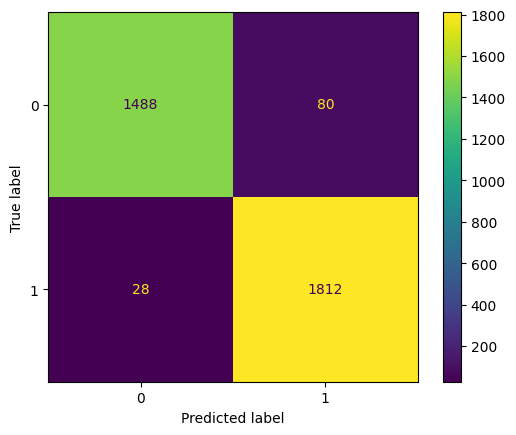

In [127]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, Y_test)

# Best Model is K-Nearest Neighbor(KNN) with Accuracy 96.66%